In [2]:
import sys
sys.path.append('../')

import torch
import imageio as iio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from utils.mart_loss import mart_loss
from tqdm import tqdm
from utils.operations import save_checkpoint

In [11]:
class MyDataset(Dataset):
    def __init__(self, db_path, transform=None, target_transform=None):
        self.db_path = db_path
        self.transform = transform
        self.target_transform = target_transform
        self.entries = self.create_list() # [(image, label)]

    def create_list(self):
        folders = os.listdir(self.db_path)
        entries = []
        for i in range(len(folders)):
            image_paths = os.listdir(os.path.join(self.db_path, folders[i]))
            for path in image_paths:
              img_path = os.path.join(self.db_path, folders[i], path)
              image = iio.imread(img_path)
              entries.append((image, i))
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        image = self.entries[idx][0]
        label = self.entries[idx][1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
def process_data(batch_sz, shuffle=True, random_seed=2000):

  transform = transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize([224,224]),
      transforms.ToTensor()
  ])

  dataset = MyDataset("../dataset/", transform)

  num = len(dataset)
  indices = list(range(num))
  split = int(np.floor(0.2 * num)) # 20% test split

  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, test_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_sz, sampler=test_sampler, pin_memory=True)

  return train_loader, test_loader

In [13]:
batch_sz=16 # this is batch size i.e. the number of rows in a batch of data
train_loader, test_loader = process_data(batch_sz)

C:\Users\Kuka Team\AppData\Local\Temp\ipykernel_13664\1934560902.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = iio.imread(img_path)


In [14]:
def label_str(x):
  labels = ["metal", "misc", "plastic", "glass", "paper", "cardboard"]
  return(labels[x])

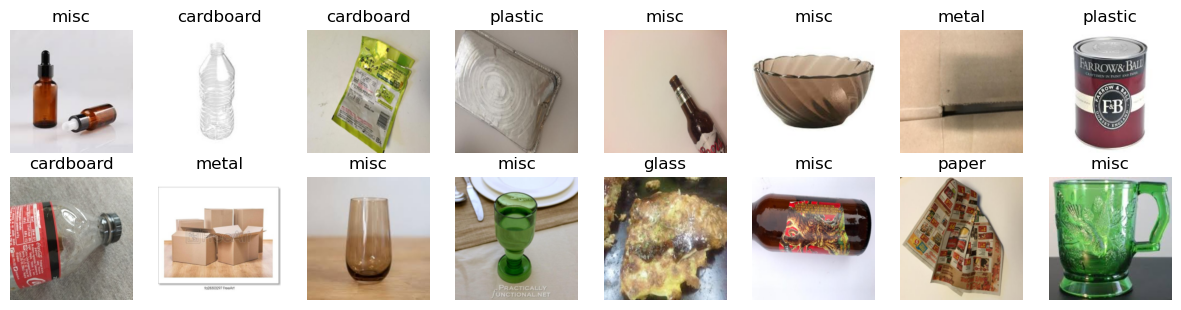

In [15]:
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
plt.figure(figsize=(15,15))
for i in range(16):
  plt.subplot(8,8,i+1)
  img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
  plt.imshow(img)
  plt.title(label_str(labels[i].item()))
  plt.axis("off")

In [6]:
def test(model, device):
    model.eval()

    predictions = []
    true = []

    with torch.no_grad():

        total_loss = 0
        acc_test = 0
        total_test = 0
        
        for batch in test_loader:
            data = batch[0]
            label = batch[1]
            data, label = data.to(device), label.to(device)
            logits = model(data)
            if isinstance(logits, tuple):  # If the model returns a tuple
                logits = logits[0]
            else:  # If the model returns a single tensor
                logits = logits
            
            predictions.extend(torch.argmax(logits, dim=1).cpu().detach().numpy())
            true.extend(label.cpu().detach().numpy())
            
            loss = F.cross_entropy(logits, label)
            total_loss += loss.item()
            out = torch.argmax(logits, dim=1)
            acc_test += torch.sum(out == label)
            total_test += logits.shape[0]
        
        avg_accuracy = acc_test / total_test

        return avg_accuracy, predictions, true

In [7]:
def train(model, num_epochs, lr, momentum):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
    train_losses = []
    
    best_epoch = 0
    best_acc = 0

    for i in range(num_epochs):
        loss_total = 0
        acc_train = 0
        total_train = 0

        # Progress bar for batches
        with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {i+1}", unit="batch") as batches:
            for ii, batch in batches:
                x = batch[0].to(device)
                y = batch[1].to(device)

                optimizer.zero_grad()
                loss, yhat = mart_loss(model, x, y, optimizer)

                loss_total += loss.item()
                loss.backward()
                optimizer.step()

                acc_train += torch.sum(torch.argmax(yhat, dim=1) == y)
                total_train += yhat.shape[0]

                # Update the batch progress bar description with the current loss and accuracy
                train_loss_avg = loss_total / (ii + 1)  # Ensure correct averaging
                train_acc_avg = acc_train.item() / total_train
                batches.set_postfix(loss=train_loss_avg, accuracy=train_acc_avg)

        if i % 2 == 0:
            acc_test,_,_ = test(model, device)
            save_checkpoint(model, optimizer, i+1, train_loss_avg, f"../checkpoints/model_{i+1}.pth")

            print(f"Epoch {i+1}: Testing Accuracy: {acc_test:.4f}")

            if acc_test > best_acc:
                best_acc = acc_test
                best_epoch = i+1

        train_losses.append(train_loss_avg)

        lr_scheduler.step()

        # Print information for this epoch
        print(f"Epoch {i+1}: Training Loss: {train_loss_avg:.4f}, Training Accuracy: {train_acc_avg:.4f}")

    print(f"Final Training Loss: {train_loss_avg:.4f}")
    print(f"Final Training Accuracy: {train_acc_avg:.4f}")

    print(f"Best epoch: {best_epoch}")

    # Plot the data
    plt.plot(train_losses, label='Training Loss')

    # Add legend, title, and labels
    plt.legend()
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # Display the graph
    plt.show()

    return train_losses

In [17]:
model_classification = models.resnet50(pretrained=True)
model_classification.fc = nn.Linear(in_features=2048, out_features=6, bias=True)

# model_detection = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Epoch 1: 100%|██████████| 561/561 [07:29<00:00,  1.25batch/s, accuracy=0.397, loss=2.12]


Epoch 1: Training Loss: 2.1200, Training Accuracy: 0.3972


Epoch 2: 100%|██████████| 561/561 [07:29<00:00,  1.25batch/s, accuracy=0.516, loss=1.82]


Epoch 2: Training Loss: 1.8208, Training Accuracy: 0.5163


Epoch 3: 100%|██████████| 561/561 [07:29<00:00,  1.25batch/s, accuracy=0.586, loss=1.72]


Epoch 3: Training Loss: 1.7159, Training Accuracy: 0.5858


Epoch 4: 100%|██████████| 561/561 [07:30<00:00,  1.25batch/s, accuracy=0.623, loss=1.66]


Epoch 4: Training Loss: 1.6595, Training Accuracy: 0.6230


Epoch 5: 100%|██████████| 561/561 [07:29<00:00,  1.25batch/s, accuracy=0.653, loss=1.6] 


Epoch 5: Training Loss: 1.6000, Training Accuracy: 0.6533


Epoch 6: 100%|██████████| 561/561 [07:28<00:00,  1.25batch/s, accuracy=0.682, loss=1.56]


Epoch 6: Training Loss: 1.5569, Training Accuracy: 0.6825


Epoch 7: 100%|██████████| 561/561 [07:37<00:00,  1.23batch/s, accuracy=0.706, loss=1.5] 


Epoch 7: Training Loss: 1.5018, Training Accuracy: 0.7057


Epoch 8: 100%|██████████| 561/561 [07:43<00:00,  1.21batch/s, accuracy=0.723, loss=1.46]


Epoch 8: Training Loss: 1.4597, Training Accuracy: 0.7228


Epoch 9: 100%|██████████| 561/561 [07:41<00:00,  1.22batch/s, accuracy=0.741, loss=1.4] 


Epoch 9: Training Loss: 1.4035, Training Accuracy: 0.7413


Epoch 10: 100%|██████████| 561/561 [07:33<00:00,  1.24batch/s, accuracy=0.759, loss=1.36]


Epoch 10: Training Loss: 1.3595, Training Accuracy: 0.7586


Epoch 11: 100%|██████████| 561/561 [07:26<00:00,  1.26batch/s, accuracy=0.768, loss=1.32]


Epoch 11: Training Loss: 1.3243, Training Accuracy: 0.7682


Epoch 12: 100%|██████████| 561/561 [07:26<00:00,  1.26batch/s, accuracy=0.789, loss=1.29]


Epoch 12: Training Loss: 1.2857, Training Accuracy: 0.7885


Epoch 13: 100%|██████████| 561/561 [07:26<00:00,  1.26batch/s, accuracy=0.803, loss=1.24]


Epoch 13: Training Loss: 1.2352, Training Accuracy: 0.8026


Epoch 14: 100%|██████████| 561/561 [07:26<00:00,  1.26batch/s, accuracy=0.815, loss=1.19]


Epoch 14: Training Loss: 1.1911, Training Accuracy: 0.8149


Epoch 15: 100%|██████████| 561/561 [07:27<00:00,  1.25batch/s, accuracy=0.818, loss=1.18]


Epoch 15: Training Loss: 1.1769, Training Accuracy: 0.8184


Epoch 16: 100%|██████████| 561/561 [07:37<00:00,  1.23batch/s, accuracy=0.835, loss=1.1] 


Epoch 16: Training Loss: 1.0955, Training Accuracy: 0.8349


Epoch 17: 100%|██████████| 561/561 [07:39<00:00,  1.22batch/s, accuracy=0.853, loss=1.06]


Epoch 17: Training Loss: 1.0590, Training Accuracy: 0.8535


Epoch 18: 100%|██████████| 561/561 [07:40<00:00,  1.22batch/s, accuracy=0.853, loss=1.02]


Epoch 18: Training Loss: 1.0230, Training Accuracy: 0.8534


Epoch 19: 100%|██████████| 561/561 [07:40<00:00,  1.22batch/s, accuracy=0.87, loss=0.978] 


Epoch 19: Training Loss: 0.9777, Training Accuracy: 0.8699


Epoch 20: 100%|██████████| 561/561 [07:36<00:00,  1.23batch/s, accuracy=0.879, loss=0.942]

Epoch 20: Training Loss: 0.9424, Training Accuracy: 0.8790
Final Training Loss: 0.9424
Final Training Accuracy: 0.8790


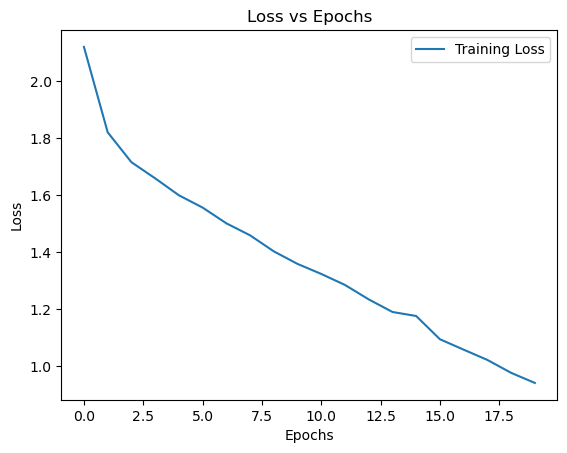

[2.1199681338141945,
 1.8207938673237003,
 1.7159026659321233,
 1.6594851977472425,
 1.6000446653833575,
 1.5569028568565315,
 1.5018027454561516,
 1.4597015810097815,
 1.4035071895296773,
 1.3594714463713335,
 1.3243305689510814,
 1.285746080458908,
 1.2351594669296142,
 1.1910689627210511,
 1.176916810652364,
 1.095480028108267,
 1.0589532845798024,
 1.0229778577193431,
 0.9777491421516779,
 0.9424296954311364]

In [18]:
torch.backends.cudnn.benchmark = True
train(model_classification, 20, 2e-3, 0.9)

In [ ]:
def confusion_matrix(true, predictions):
  # Compute the confusion matrix for training data
  ax = plt.subplot()
  cm = confusion_matrix(true, predictions)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

  # Set labels, title, and tick parameters
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5)])
  ax.yaxis.set_ticklabels([label_str(0), label_str(1), label_str(2), label_str(3), label_str(4), label_str(5)], rotation=0, ha='right')

  # Rotate the tick labels for better readability
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

  # Display the plot
  plt.tight_layout()
  plt.show()

In [ ]:
torch.save(model_classification, "../model/trash.pth")